- Exercici 1
Descarrega el dataset adjunt, de registres de publicacions a Facebook sobre Tailàndia, i classifica els diferents registres utilitzant l'algorisme de K-means.

 Important

Tingues en compte que prèviament et caldrà preparar el dataset.



- Exercici 2
Classifica els diferents registres utilitzant l'algorisme de clustering jeràrquic.



- Exercici 3
Calcula el rendiment del clustering mitjançant un paràmetre com pot ser silhouette.



In [1214]:
import pandas as pd
import numpy as np



from sklearn.preprocessing  import RobustScaler
from sklearn.decomposition import PCA


import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("Publicacions Facebook Thailandia (1).csv")
df.head(5)


,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,246675545449582_1649696485147474,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,246675545449582_1649426988507757,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,246675545449582_1648730588577397,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,246675545449582_1648576705259452,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,246675545449582_1645700502213739,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN


In [1215]:
df.isnull().sum()

status_id              0
status_type            0
status_published       0
num_reactions          0
num_comments           0
num_shares             0
num_likes              0
num_loves              0
num_wows               0
num_hahas              0
num_sads               0
num_angrys             0
Column1             7050
Column2             7050
Column3             7050
Column4             7050
dtype: int64

 Vemos columnas vacías (7050 null) y dtypes que no nos convienen (object). Haremos limpieza 


In [1216]:
# Convert dtypes

df = df.convert_dtypes()



 # columnas Null

df = df.drop(['Column1','Column2','Column3','Column4'], axis = 1)


# Eliminamos tb la columna status_id pues no vemos que info nos puede aportar 

df = df.drop(['status_id'], axis = 1)



# convertimos la columna status_published  a un formato datetime

df['status_published'] = pd.to_datetime(df['status_published'], format='%m/%d/%Y %H:%M')



df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   status_type       7050 non-null   string        
 1   status_published  7050 non-null   datetime64[ns]
 2   num_reactions     7050 non-null   Int64         
 3   num_comments      7050 non-null   Int64         
 4   num_shares        7050 non-null   Int64         
 5   num_likes         7050 non-null   Int64         
 6   num_loves         7050 non-null   Int64         
 7   num_wows          7050 non-null   Int64         
 8   num_hahas         7050 non-null   Int64         
 9   num_sads          7050 non-null   Int64         
 10  num_angrys        7050 non-null   Int64         
dtypes: Int64(9), datetime64[ns](1), string(1)
memory usage: 667.9 KB


In [1217]:
df['status_type'].unique()

<StringArray>
['video', 'photo', 'link', 'status']
Length: 4, dtype: string

No nos vayamos a olvidar de eliminar los valores duplicados...

In [1218]:
df.shape

(7050, 11)

In [1255]:
df = df.drop_duplicates(ignore_index = True) 

In [1256]:
df.shape

(6996, 11)

Efectivamente, eliminamos 54 elementos duplicados.\
Veamos si existen correlaciones relevantes.

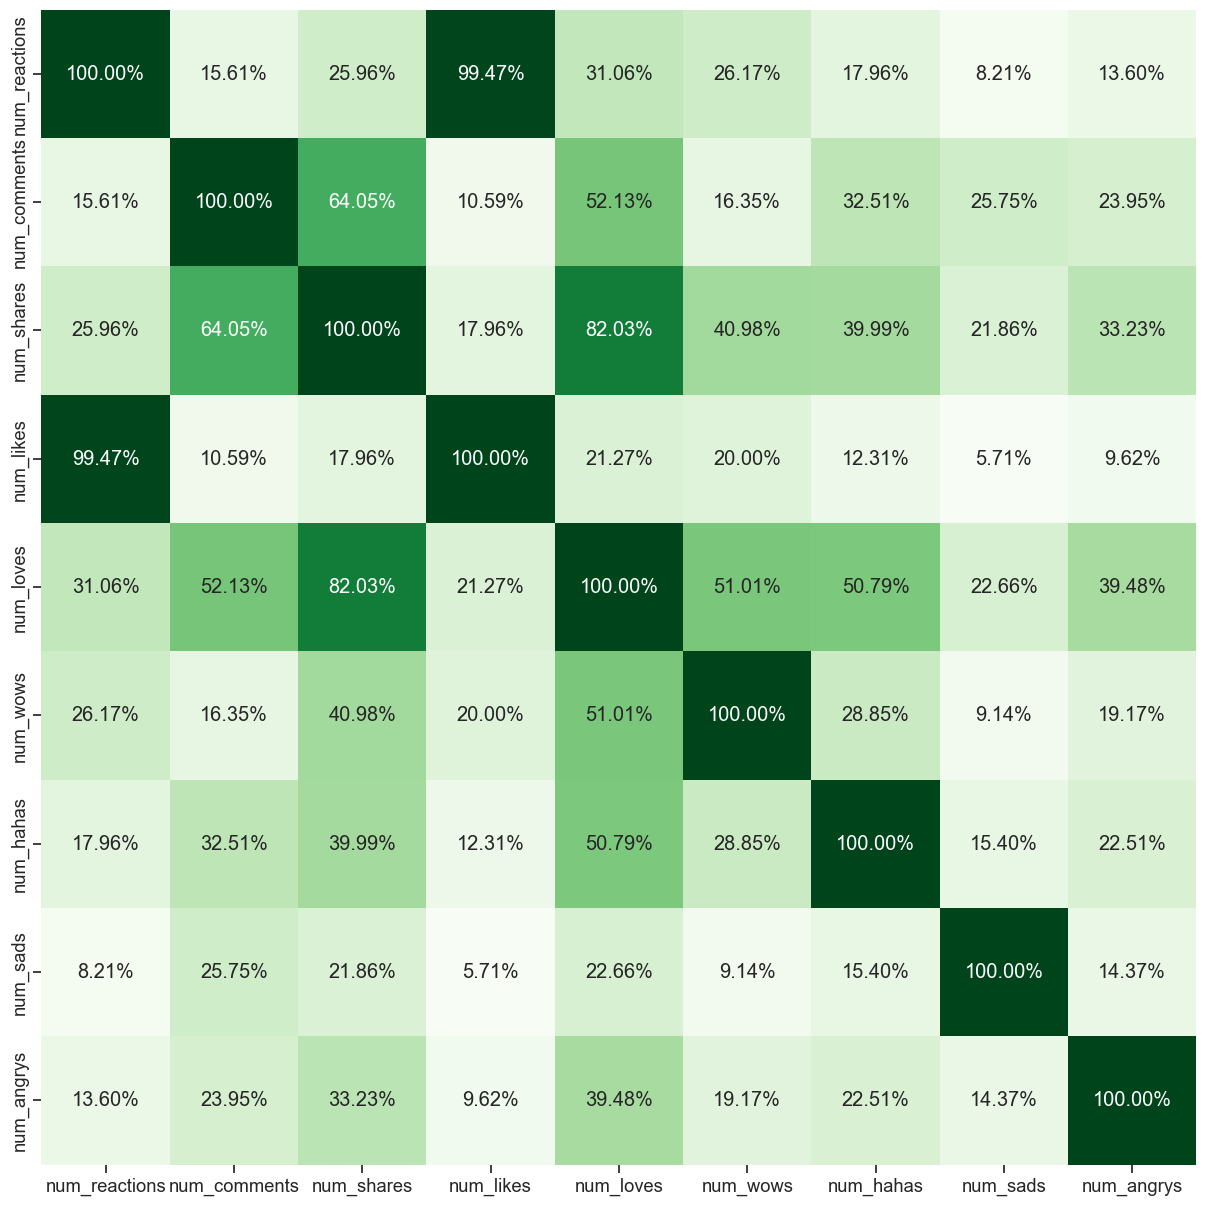

In [1221]:
corr = df.corr()

plt.figure(figsize=(15,15))


heatmap =sns.heatmap(corr, cbar = False, square= True, fmt='.2%', annot=True, cmap='Greens')




Vemos altas correlaciones entre :






num_reactions y num_likes : 99,49% ( el 99% de las reacciones suelen ser Likes o viceversa)

    
num_comments y num_shares : 64,06% ( Si hay comment ( o Share) , en el 64% de los casos se comparte/share ( o viceversa...)


num_shares y num_Loves    : 82% ( Si se comparte ( o se marca Love, en el 82% de los casos habrá Love ( o se viceversa..)


# Normalidad y outliers 

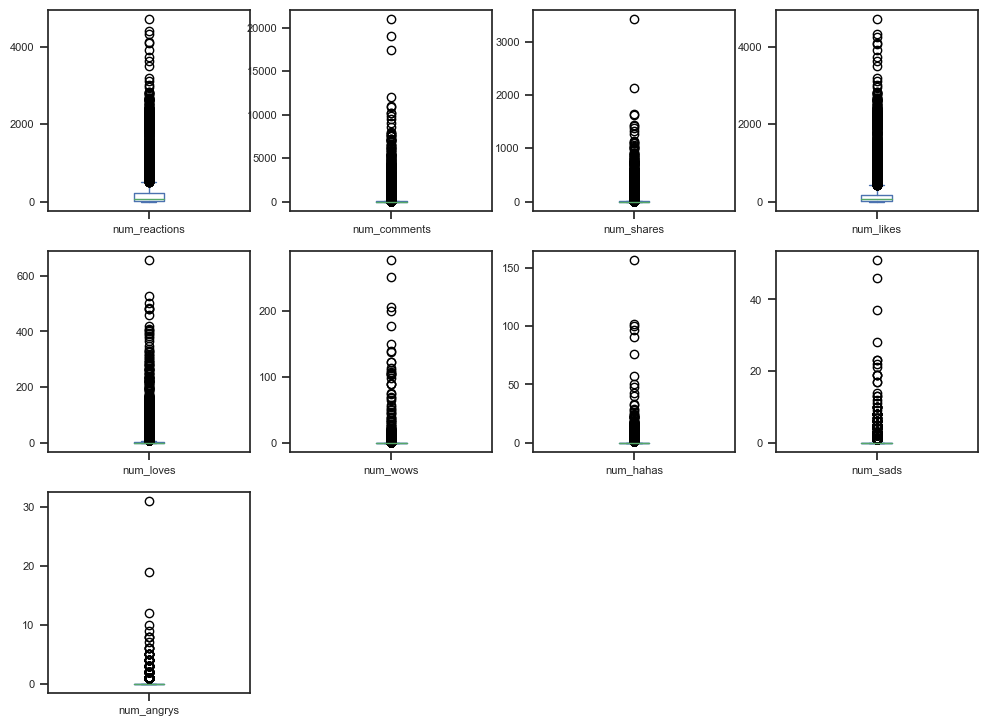

In [1222]:
# Outliers

df.plot(kind='box', subplots=True, layout=(4,4), fontsize=8, figsize=(12,12));

Todas tienen outliers, posiblemente apliquemos RobustScaler en el preprocesado.
Vamos a mirar cual es la distibución (  Normalidad/ Gaussiana  ) 

In [1223]:
# Queremos Aplicar Shapiro pero nos "saltará" para valores no numéricos . 
#Podríamos hacer un  if values.dtypes = 'int64' pero crearemos un nuevo índice.columns sobre el que tenga que iterar. 

columns_numeric = ['num_reactions','num_comments','num_shares','num_likes','num_loves','num_hahas','num_sads','num_angrys']

In [1224]:
#Normalidad . Comprobamos si las variables numéricas son gaussianas o no, para ver si usamos RobustScaler

from scipy.stats import shapiro
    
for i in columns_numeric:
        data = df[i]       
        stat, p = shapiro(data)
        print('stat=%.3f, p=%.3f' % (stat, p))
        if p > 0.05:
            print(i+  '  Probablemente gaussiana')
        else:
                print(i + '   Probablemente no gaussiana')


stat=0.508, p=0.000
num_reactions   Probablemente no gaussiana
stat=0.262, p=0.000
num_comments   Probablemente no gaussiana
stat=0.338, p=0.000
num_shares   Probablemente no gaussiana
stat=0.487, p=0.000
num_likes   Probablemente no gaussiana
stat=0.353, p=0.000
num_loves   Probablemente no gaussiana
stat=0.148, p=0.000
num_hahas   Probablemente no gaussiana
stat=0.136, p=0.000
num_sads   Probablemente no gaussiana
stat=0.141, p=0.000
num_angrys   Probablemente no gaussiana


Las variables  tienen una distribución no gaussiana, podremos aplicar Robust Scaler.

# PCA

In [1270]:
names = df.columns
names

Index(['status_type', 'status_published', 'num_reactions', 'num_comments',
       'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas',
       'num_sads', 'num_angrys'],
      dtype='object')

 Aplicamos una standarización previa para columnas numéricas. 
Crearemos previamente los dummies para status_type ( categórica) y así podremos eliminarla y tendremos vía libre para aplicar RobustScaler . 
Más adelante haremos un Concat entre el Dataframe de las PCA y estos Dummies y obtendremos el DF con el que testear Kmeans


In [1271]:
# Creamos Dummies para la columna  'status_type' : Video/ Photo.....dtype = int64
# Alana me sugirió drop_first = True para evitar colinealidad pero si lo ejecuto, efectivamente, desaparece la Columna para Link

z = pd.get_dummies(df['status_type'], drop_first=True, dtype='int64')

z

,photo,status,video
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,1,0,0
...,...,...,...
6991,1,0,0
6992,1,0,0
6993,1,0,0
6994,1,0,0


In [1272]:
# Eliminamos la col.status_type una vez ya hemos creado los dummies, eliminampos tb la columna  status_published 

df1 = df.drop(['status_type','status_published'], axis = 1)
df1.shape

(6996, 9)

In [1273]:
# Podemos aplicar un RobustScaler pues no tienen una distribución Normal ( Gaussiana )

names = df1.columns
Scaled_df = RobustScaler().fit_transform(df1) 
df_scaled = pd.DataFrame(Scaled_df, columns = names)
df_scaled.head()  

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,2.366834,22.831461,65.50,2.272727,30.666667,3.0,1.0,1.0,0.0
1,0.462312,-0.179775,0.00,0.563636,0.000000,0.0,0.0,0.0,0.0
2,0.849246,10.426966,14.25,0.890909,7.000000,1.0,1.0,0.0,0.0
3,0.266332,-0.179775,0.00,0.327273,0.000000,0.0,0.0,0.0,0.0
4,0.778894,-0.179775,0.00,0.890909,3.000000,0.0,0.0,0.0,0.0



Vamos a buscar el nº de dimensiones que optimizan la extracción de Varianza con el mínimo numero de características del dataset : PCA

In [1274]:
#Iniciamos PCA, queremos conservar 90% de la varianza 

from sklearn.decomposition import PCA


pca = PCA(0.90)

# Fit_transform

data_pca = pca.fit_transform(df_scaled)
pca.n_components_ 

2

Nos dice que con los 2 primeros PCA mantendríamos esta varianza ( 90% )

In [1275]:
pca.components_df = pd.DataFrame(data_pca, columns = ['PCA1','PCA2'])
pca.components_df

,PCA1,PCA2
0,48.357696,38.956244
1,-14.809157,-2.187481
2,3.390220,3.411421
3,-14.813287,-2.194082
4,-14.196754,-1.345622
...,...,...
6991,-14.815616,-2.197805
6992,-14.722787,-2.090011
6993,-14.757526,-2.120176
6994,-10.971379,1.601805


In [1290]:
# panda concat una vez tenemos los dummies para Video, photo y tenemos los pca.components_


df_def = pd.concat([pca.components_df, z], axis = 1, copy = False)
df_def1= df_def.dropna( axis=0)
df_def1





,PCA1,PCA2,photo,status,video
0,48.357696,38.956244,0,0,1
1,-14.809157,-2.187481,1,0,0
2,3.390220,3.411421,0,0,1
3,-14.813287,-2.194082,1,0,0
4,-14.196754,-1.345622,1,0,0
...,...,...,...,...,...
6991,-14.815616,-2.197805,1,0,0
6992,-14.722787,-2.090011,1,0,0
6993,-14.757526,-2.120176,1,0,0
6994,-10.971379,1.601805,1,0,0


In [1277]:
# Medimos ajuste modelo

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)


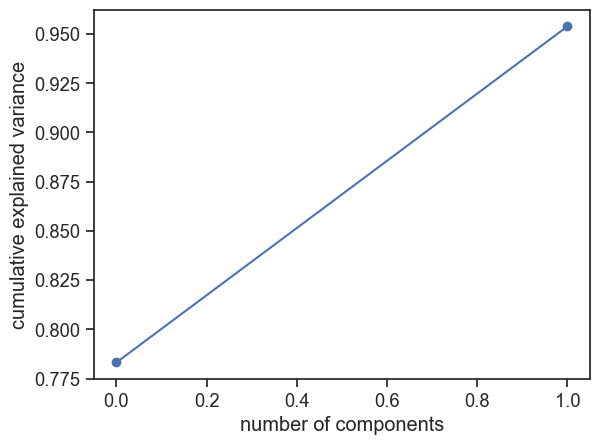

In [1278]:
# Plot
plt.plot(cumulative_explained_variance, marker = "o")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

 Segun el gráfico, con 2 components abarcaríamos más del 90% de la varianza (info) del dataset .


# KMEANS

In [1279]:
#Vamos a buscar el nº óptimo de cluster con el método Elbow

from sklearn.cluster import KMeans
inertia = []
K = range(1,10)
algorithm = 'elkan'

for k in range ( 1,10) :
    Kmeans = KMeans(n_clusters=k, max_iter = 100, random_state = 42,algorithm = algorithm)
    Kmeans.fit_predict(df_def1)
    inertia.append(Kmeans.inertia_)

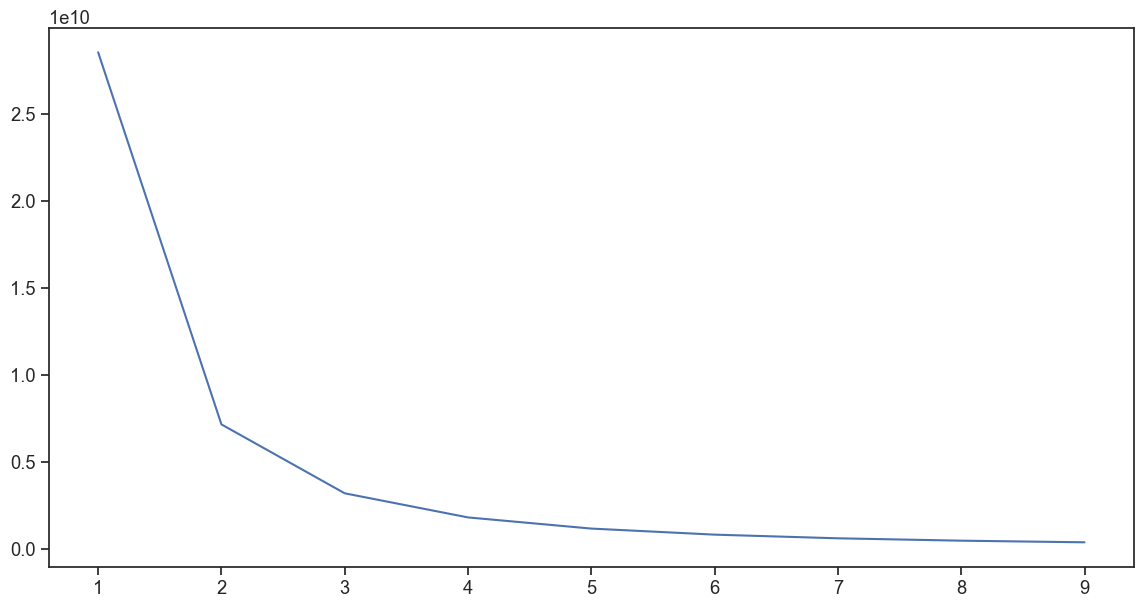

In [1266]:
# Plot

plt.figure(figsize=(14,7))
plt.plot(K, inertia)



 Vemos que el punto de inflexión corresponde a 2 Clusters (o 3 Clusters...) ( resultado que concuerda con PCA a 0.90% Varianza)
 
 
 

In [1288]:
# Training del modelo con n_clusters = 2 clusters


Kmeans_2 = KMeans(n_clusters=2,
                  max_iter = 1000, 
                  random_state = 42,
                  algorithm = 'elkan')

In [1291]:
# Ajustamos a nuestros datos ( obtenemos Clusters :  Y )

Y_k2 = Kmeans_2.fit_predict(df_def1)
Y_k2

array([0, 0, 0, ..., 0, 0, 0])

In [1320]:
# Añadimos Labels que acabamos de crear al df: 

df_def['Cluster']= Y_k2
df_scaled['Cluster'] = Y_k2
df_def

,PCA1,PCA2,photo,status,video,Cluster
0,48.357696,38.956244,0,0,1,0
1,-14.809157,-2.187481,1,0,0,0
2,3.390220,3.411421,0,0,1,0
3,-14.813287,-2.194082,1,0,0,0
4,-14.196754,-1.345622,1,0,0,0
...,...,...,...,...,...,...
6991,-14.815616,-2.197805,1,0,0,0
6992,-14.722787,-2.090011,1,0,0,0
6993,-14.757526,-2.120176,1,0,0,0
6994,-10.971379,1.601805,1,0,0,0


In [1322]:
# Evaluamos el rendimiento de este clustering K_2 : SSE y Silhouette
#SSE


sse_k2 = Kmeans_2.inertia_
sse_k2

8918904.049421929

In [1323]:
#Silhouette


from sklearn.metrics import silhouette_score
silhouette_k2 = silhouette_score(df_def,Kmeans_2.labels_)

silhouette_k2




0.9009213206078203

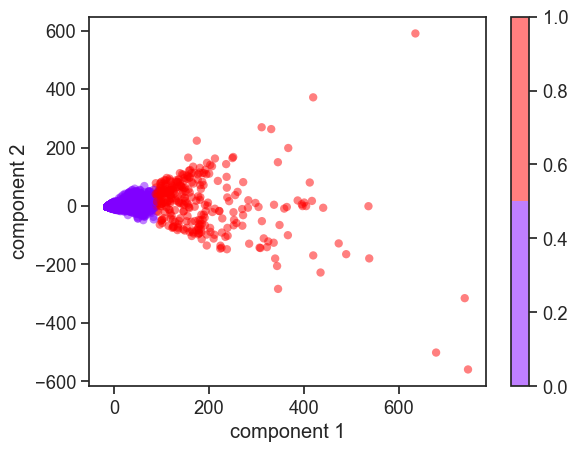

In [1317]:
#Scatterplot de los Components 

plt.scatter(df_def['PCA1'], df_def['PCA2'],
            c=df_def['Cluster'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('rainbow', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Se distinguen claramente los dos clusters que habíamos anticipado con Kmeans

# Hierarchical clustering

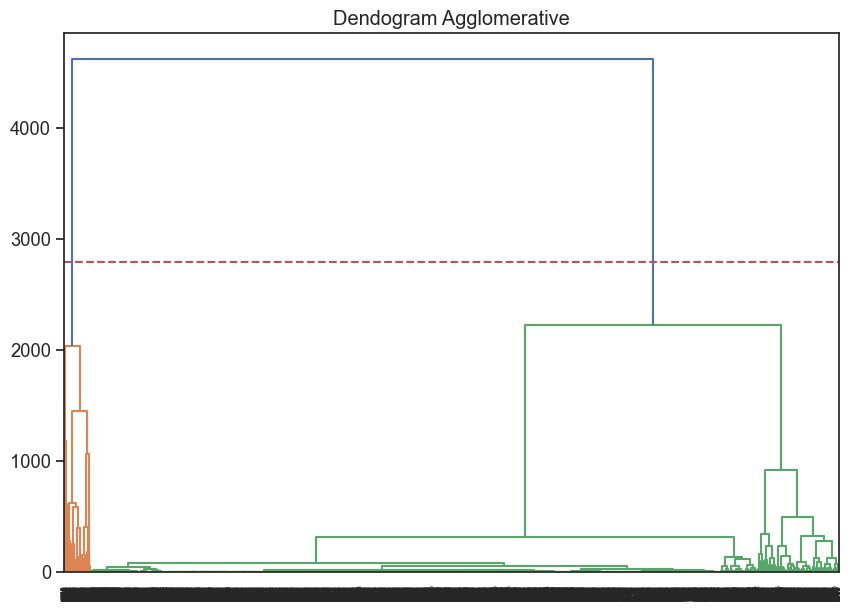

In [1326]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
dend_ward = shc.dendrogram(shc.linkage(df_def, method='ward'))
plt.title("Dendogram Agglomerative")
plt.axhline(y=2800, color='r', linestyle='--')
plt.show()

Difícil confirmar el numero òptimo de clusters. hagamos  Silhouette para buscar el nº óptimo de Clusters

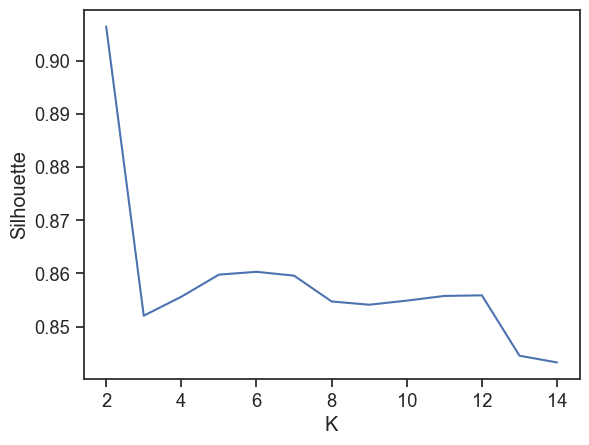

In [1328]:
silhouette = []

for k in range(2, 15):
    AG = AgglomerativeClustering(n_clusters=k ,affinity='euclidean', linkage='ward')
    cluster_labels = AG.fit_predict(df_def)
    silhouette.append((silhouette_score(df_def, cluster_labels)))

#print(silhouette_coefficients_HC)

plt.plot(range(2, 15), silhouette)
plt.xlabel('K')
plt.ylabel('Silhouette')
plt.show()



2 Clusters serían el óptimo si utilizamos Hierarchical clustering.\
Confirma los resultados previos de Kmeans
Aplicamos este nº óptimo de Cluster 

In [1329]:
from sklearn.cluster import AgglomerativeClustering

cluster2 = AgglomerativeClustering(n_clusters = 2 , affinity = 'euclidean', linkage = 'ward')    
cluster2.fit_predict(df_def)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Concuerda con los resultados de KMEANS

In [1349]:
#Silhouette K = 2 

from sklearn.metrics import silhouette_score
silhouette_AGG = silhouette_score(df_def,cluster2.fit_predict(df_def))

silhouette_AGG

0.9064558276194543

Muy buen resultado , muy próximo a 1 . Parece que 2 és el nº óptimo de Clusters.\


# EX3

In [1377]:
#Resumen de Scores:

data = [['', 0.899], ['', 0.906]]
 
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['','silhouette'] ,index =['KMEANS', 'AGG'])
 
# print dataframe.
print(df)


          silhouette
KMEANS         0.899
AGG            0.906


Vamos a buscar las características de estos dos clusters

In [1369]:
# Calculamos las medias por segmentos 



df_pca_freq = df_scaled.groupby(['Cluster']).mean()

df_pca_freq.T

Cluster,0,1
num_reactions,0.733886,3.136315
num_comments,3.607938,147.930104
num_shares,4.767270,125.191558
num_likes,0.840370,2.819362
num_loves,2.389703,44.698052
num_wows,0.622010,14.964286
num_hahas,0.367972,7.870130
num_sads,0.154007,1.941558
num_angrys,0.066388,1.061688


Conclusiones :

Cluster 0 con más engagement 
Cluster 1 con más difusión
    
    